In [1]:
from shared.preface import *
import shared.functions as fct

## Ch. 0: Preliminary Investigations.

### 2D grid, center coord. pairs.

In [ ]:
def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

### 3D grid, center coord. pairs.

In [ ]:
# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

## Ch. 1: Milky Way-type halo and simple grid.

### 3D plot of the DM particles.

In [ ]:
snap = '0036'
sim_ID = 'L006N188'
m0 = '2.59e+11'
proj = 2

# Uncomment for interactive 3D plot.
# %matplotlib widget

# Generate files with positions of DM particles
fct.read_DM_positions(
    which_halos='halos', mass_select=12,  # unnecessary when giving index...
    random=False, snap_num=snap, sim=sim_ID, 
    halo_index=int(proj), init_m=m0
)

# Build grid around Milky Way.
MW_grid = fct.grid_3D(GRID_L, GRID_S) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load(
    f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
)

print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = MW_grid[:,0], MW_grid[:,1], MW_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

plt.show()

### Calculate gravity in each cell.

In [ ]:
def cell_gravity(cell_coords, DM_coords, grav_range, m_DM):
    
    # Center all DM positions w.r.t. cell center.
    DM_cc = DM_coords*kpc - cell_coords

    # Calculate distances of DM to cc, sorted in ascending order.
    DM_dist = np.sqrt(np.sum(DM_cc**2, axis=1))

    # Ascending order indices.
    ind = DM_dist.argsort()

    # Truncate DM positions depending on distance to cc.
    DM_pos_sort = DM_cc[ind]
    DM_dist_sort = DM_dist[ind]

    #note: there is a particle exactly at (0,0,0), which causes infinities...
    #? for now manually remove it and discuss with Camila...
    DM_pos_sort = DM_pos_sort[1:]
    DM_dist_sort = DM_dist_sort[1:]

    if grav_range is None:
        DM_pos_inRange = DM_pos_sort
        DM_dist_inRange = DM_dist_sort
    else:
        DM_pos_inRange = DM_pos_sort[DM_dist_sort <= grav_range]
        DM_dist_inRange = DM_dist_sort[DM_dist_sort <= grav_range]

    # Adjust the distances array to make it compatible with DM positions array.
    DM_dist_inRange_sync = DM_dist_inRange.reshape(len(DM_dist_inRange),1)
    DM_dist_inRange_rep = np.repeat(DM_dist_inRange_sync, 3, axis=1)

    ### Calculate superposition gravity.
    pre = G*m_DM
    quotient = (cell_coords-DM_pos_inRange)/(DM_dist_inRange_rep**3)
    derivative = pre*np.sum(quotient, axis=0)

    #NOTE: Minus sign, s.t. velocity changes correctly (see notes).
    return np.asarray(-derivative, dtype=np.float64)


DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')

# For position of Sun/Earth.
cell_coords = np.array([8.5, 0, 0])*kpc
cell_vector = cell_gravity(cell_coords, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print('Position of Sun/Earth:')
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)), '\n')

# For position of Sun/Earth.
cell_coords = np.array([0., 0, 0])*kpc
cell_vector = cell_gravity(cell_coords, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print('Position close to center:')
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)), '\n')

# For position of Sun/Earth.
cell_coords = np.array([333., 0, 0])*kpc
cell_vector = cell_gravity(cell_coords, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print('Position at virial radius:')
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)))

#! values should be around same order of magnitude as in spher. symmetric setup.

## Ch. 2: Broadcasting for cell_gravity: tests for gravity_range.

### Comparing finite to infinite grav_range:

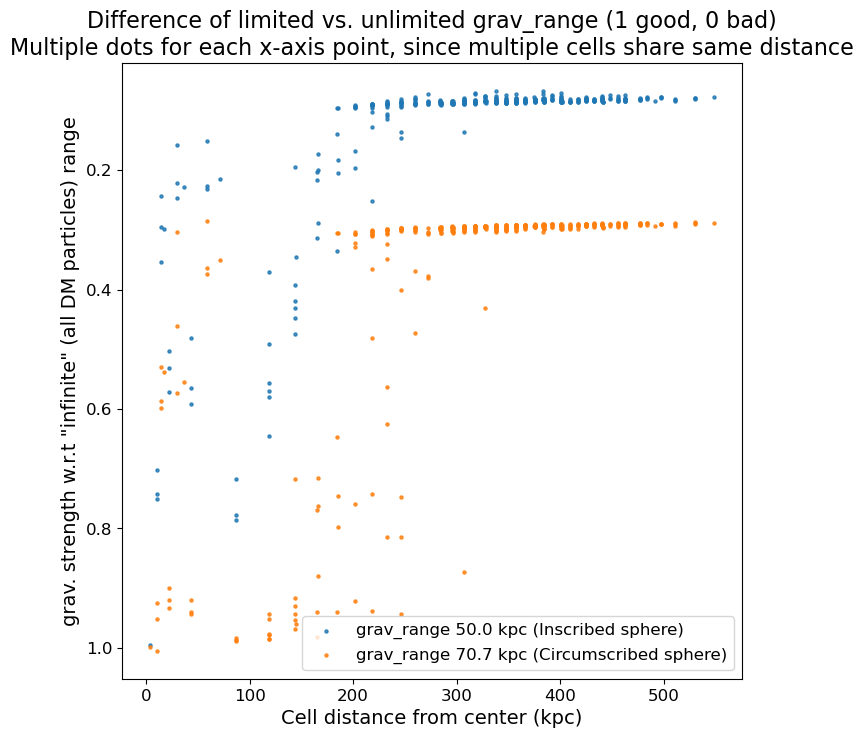

In [3]:
snap = '0036'
sim_ID = 'L006N188'
m0s = ['1.89e+12', '4.32e+11', '2.59e+11']
projs = [0,1,2]

for m0, proj in zip(m0s, projs):

    # Comment out to iterate over all halos in m0s.
    if proj != 2:
        continue

    # Generate files with positions of DM particles
    fct.read_DM_positions(
        which_halos='halos', mass_select=12,  # unnecessary when giving index...
        random=False, snap_num=snap, sim=sim_ID, 
        halo_index=int(proj), init_m=m0
    )

    # Read in DM particle positions.
    DM_raw = np.load(
        f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
    )[::1]*kpc
    # print(len(DM))


adapted_cc = np.load(
    f'CubeSpace/adapted_cc_{SIM_ID}_snapshot_{snap}.npy'
)
cell_com = np.load(
    f'CubeSpace/cell_com_{SIM_ID}_snapshot_{snap}.npy'
)
DM_count = np.load(
    f'CubeSpace/DM_count_{SIM_ID}_snapshot_{snap}.npy'
)
DM_pos = np.expand_dims(DM_raw, axis=0)
adapted_DM = np.repeat(DM_pos, len(adapted_cc), axis=0)


fig, ax = plt.subplots(1,1, figsize=(8,8))


ranges = [GRID_S/2., GRID_S/np.sqrt(2)]
labels = ['Inscribed sphere', 'Circumscribed sphere']
for rangeX, l0 in zip(ranges, labels):

    fct.cell_gravity_3D(
        adapted_cc, cell_com, adapted_DM, DM_count, 
        None, DM_SIM_MASS, snap
    )
    dPsi_grid_None = np.load(f'CubeSpace/dPsi_grid_snapshot_{snap}.npy')
    mags_None = np.sqrt(np.sum(dPsi_grid_None**2, axis=1))

    fct.cell_gravity_3D(
        adapted_cc, cell_com, adapted_DM, DM_count, 
        rangeX, DM_SIM_MASS, snap
    )
    dPsi_grid_rangeX = np.load(f'CubeSpace/dPsi_grid_snapshot_{snap}.npy')
    mags_rangeX = np.sqrt(np.sum(dPsi_grid_rangeX**2, axis=1))

    # Sort cells by distance from center (0,0,0).
    grid_dis = np.sqrt(np.sum(adapted_cc**2, axis=2)).flatten()
    dis_ind = grid_dis.argsort()
    grid_dis = grid_dis[dis_ind]
    mags_None = mags_None[dis_ind]
    mags_rangeX = mags_rangeX[dis_ind]

    diff = (mags_None-mags_rangeX)/mags_None
    ax.scatter(
        grid_dis/kpc, diff, s=5, alpha=0.8, 
        label=f'grav_range {np.round(rangeX/kpc,1)} kpc ({l0})'
        )

ax.set_title(
    f'Difference of limited vs. unlimited grav_range (1 good, 0 bad)'
    '\n'
    'Multiple dots for each x-axis point, since multiple cells share same distance'
    )
ax.set_xlabel(f'Cell distance from center (kpc)')
ax.set_ylabel(f'grav. strength w.r.t "infinite" (all DM particles) range')
# ax.set_ylim(0,1)

def y_fmt_here(value, tick_number):
    return np.round(1-value,1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt_here))


plt.legend(loc='lower right')
plt.show()

### Check sim_vs_NFW_gravity.py for comparison to NFW.

## Ch. 3: Better derivative grid structure. 

In [ ]:
# Values for file reading.
sim_ID = 'L006N188'
snap = '0036'
m0 = '2.59e+11'

# Initial grid and DM positions. 
DM_raw = np.load(
    f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
)*kpc  #! needs to be in kpc
grid = fct.grid_3D(GRID_L, GRID_S)
init_cc = np.expand_dims(grid, axis=1)
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_cc), axis=0)

DM_lim = 1000

cell_division_count = fct.cell_division(
    init_cc, DM_pos_for_cell_division, GRID_S, DM_lim, None,
    sim=sim_ID, snap_num=snap
    )
adapted_cc = np.load(f'CubeSpace/adapted_cc_{sim_ID}_snapshot_{snap}.npy')

print(init_cc.shape)
print(adapted_cc.shape)

print(f'Total cell division rounds: {cell_division_count}')

### Plotting the outcome after one iteration.

In [ ]:
# Build grid around Milky Way.
new_grid = np.squeeze(adapted_cc, axis=1) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load(
    f'CubeSpace/DM_positions_{sim_ID}_snapshot_{snap}_{m0}Msun.npy'
)
print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = new_grid[:,0], new_grid[:,1], new_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

# How many DM particles inside Virial Radius?
DM_dists = np.sqrt(np.sum(DM_pos**2, axis=1))
inside_VR = DM_pos[DM_dists <= rGC]
print(len(inside_VR))

plt.show()

## Ch. 4: Tracing halo masses through snapshots.

! Now a seperate file: merger_tree.py, to generate the MergerTree file.

In [ ]:
sim_ID = 'L006N188'

# Path to merger_tree file.
tree_path = f'{pathlib.Path.cwd().parent}/neutrino_clustering_output_local/MergerTree/MergerTree_{sim_ID}.hdf5'

with h5py.File(tree_path) as tree:
    choice = 1  #note: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun
    Masses = tree['Assembly_history/Mass'][choice,:]
    zeds = tree['Assembly_history/Redshift']
    
    y = np.asarray(Masses)
    x = np.asarray(zeds)

    fig = plt.figure()
    plt.semilogy(x, y, label=f'{y[0]:.2e}')
    plt.title(u'Starting mass in labels ->')
    plt.xlabel('redshift')
    plt.ylabel('halo masses [Msun]')
    plt.legend()
    plt.show()

## Ch. 5: Long-range gravity.

In [ ]:
def DM_in_cell(cell_coords, cell_gen, DM_pos, init_grid_s):

        # Center all DM positions w.r.t. cell center.
        DM_pos -= cell_coords

        cell_len = init_grid_s/(2**cell_gen)

        DM_x = DM_pos[:,:,0]
        DM_y = DM_pos[:,:,1]
        DM_z = DM_pos[:,:,2]

        # Limit z.
        DM_zcut = DM_pos[DM_x <= ]

## Ch. 6: More DM structures.